In [1]:
import numpy as np
import json
from scipy.optimize import least_squares
from scipy.interpolate import CubicSpline
#dfbgn:
import dfbgn
#lmfit:
from lmfit import Parameters, minimize
from lmfit.printfuncs import report_fit

In [2]:
%run PES_incremental_exp.ipynb

['H3_Su_class_1.txt', 'H4_Hinde_QZ.txt', 'H3_mielke_main.txt', 'H5_Tablero.txt', 'H3_Su_class_2.txt', 'H2_Kolos.txt', 'H4_Hinde_TZ.txt', 'artificial_H2_Kolos.txt', 'H2_Wolniewicz_BO.txt', 'H3_mielke_vdw.txt', 'H3_mielke_ac.txt', 'H3_mielke_coll.txt']
dict_keys(['data', 'accuracy', 'kind', 'name', 'info']) 1409 H3
dict_keys(['kind', 'name', 'data', 'H21_data', 'H22_data', 'accuracy', 'info']) 1653 H4
dict_keys(['data', 'accuracy', 'kind', 'name', 'info']) 3263 H3
dict_keys(['info', 'accuracy', 'name', 'kind', 'data']) 2799 H5
dict_keys(['data', 'accuracy', 'kind', 'name', 'info']) 991 H3
dict_keys(['info', 'accuracy', 'name', 'kind', 'data']) 87 H2
dict_keys(['data', 'kind', 'name', 'accuracy', 'info']) 855 H4
dict_keys(['info', 'accuracy', 'name', 'kind', 'data']) 2000 H2
dict_keys(['info', 'accuracy', 'name', 'kind', 'data']) 670 H2
dict_keys(['data', 'accuracy', 'kind', 'name', 'info']) 220 H3
dict_keys(['data', 'accuracy', 'kind', 'name', 'info']) 140 H3
dict_keys(['data', 'accuracy

KeyboardInterrupt: 

KeyboardInterrupt: 

In [3]:
list_data = np.load('data/hxoy_data_corr_071021.npy', allow_pickle=True) #reload
list_data = list_data[()]
print(len(list_data))

39


general f_obj, RMSE: $\sqrt{\frac{1}{n}\sum^n_{i=1}(V_{pred} - V_{ab initio})^2}$

In [4]:
# useful analytics/statistics functions

## RMSE:
def RMSE(Y_pred, Y):
    #error between Y prediction and Y actual
    error = 0
    n = len(Y)
    for i in range(n):
        diff = (Y[i]-Y_pred[i])**2
        error += diff
    return np.sqrt(error/n)

## sech:
def sech(x):
    exp = np.exp(x)
    inv_exp = 1/exp
    return 2/(exp + inv_exp)

polynomial fit f_obj, minimize: $\sum_{i=1}^n |p(R_i) - V_i|^2$

In [214]:
'''
The models and objective functions
'''
'''Pair Potentials:'''
np.random.seed(13) #reprodicuibility

## First proposed model:
f_morse_pot = lambda r,a: np.exp(-r/a)

def f_poly(x, c): #general polynomial, evaluated at x by horner's scheme
    y = c[-1]
    for i in range(len(c)-2, -1, -1):
        y = y*x + c[i]
    return y
    
def f_monomial_diatomic_pot(r, coeffs, morse=False): #monomial pot - permutationally invariant functional 
    #r := r_i, the ith distance
    #coeffs := the coefficients, in increasing order of polynomial (0,1,2,...)
    #evaluate the polynomial by horner's scheme:
    y = r
    v = coeffs[-1]
    for i in range(len(coeffs)-2, -1, -1):
        #i := power of the polynomial
        if morse and i > 0: #exclude the constant for morse
            y = f_morse_pot(r,i)
        v = v*y + coeffs[i]
    return v

## second proposed model:
def f_diatomic_pot_lr(C, *args):
    #C = fitted coefficients, [0:len(C)] is the polynomials' coefficients c_i, [-1] is the nonlinear decaying exp coeff r_0
    ##uses *args because dfbgn doesnt accept **kwargs
    #args[0] := r, the internuclear distance
    #args[1] := Z = (Z_1, Z_2), the tuple of nuclear charges
    #M, the max polynomial degree (= len(C)-2)
    r0 = C[-1]
    r = args[0]
    Z = args[1]
    M = len(C)-2
    y = np.exp(-r/r0)
    #V = (Z[0]*Z[1])/r + C[0]
    V = (Z[0]*Z[1] + C[0])/r*(1+C[1]*(r**6))
    
    poly_V = C[-2]
    #for i in range(M-1, 1, -1): 
    for i in range(M-1, 2, -1):
        poly_V = poly_V*y + C[i]
        #print(i, poly_V, C[i])
    '''
    #non horner version:
    poly_V = 0
    #for i in range(2, M):
    for i in range(3, M): 
        poly_V += C[i]*(y**(i-3))
        #print(i, poly_V)
        #poly_V = poly_V*y + C[i-2]
    '''
    #poly_V *= ((1-y)/(r**3 + C[1]))**2
    poly_V *= ((1-y)/(r**3 + C[2]))**2
    V += poly_V
    return V


## third propopsed model:
def f_diatomic_vdw(C, *args):
    #5 free parameters
    R = args[0]
    #V_infty = args[1]
    Z = args[1] #Zi x Zj
    
    #operations:
    R2 = R**2; R4 = R2**2; R6 = R2*R4; R10 = R4*R6
    p = (C[0] + C[1]*R4)/(C[1] + R10);
    q = C[2] + C[3]*R2 + C[4]*R4
    V = (Z/R)*p - (R/q)**2
    
    return V

## CHIPR models:
### for OH+:
def f_diatomic_chipr_ohplus(C, *args):
    #free parameters, length = 19: 
    R_oh = C[0] 
    omega = C[1] 
    a = C[2:6]; 
    A = C[6:10];
    zeta = C[10];
    miu = C[11:15];
    chi = C[15:19];
    
    #fixed parameters:
    R = args[0]
    
    #operations:
    R_oh_2 = R_oh**2; R_oh_3 = R_oh_2*R_oh
    
    x = (sech((R - zeta)*miu[0])**chi[0])*a[0] \
    + (sech((R - zeta*R_oh)*miu[1])**chi[1])*a[1] \
    + (sech((R - zeta*R_oh_2)*miu[2])**chi[2])*a[2] \
    + (sech((R - zeta*R_oh_3)*miu[3])**chi[3])*a[3]
    x2 = x**2; x3 = x2*x; x4 = x3*x
    V = 8*(R**(-omega))*(x*A[0] + x2*A[1] + x3*A[2] + x4*A[3])
    return V

## Deiters + Neumaier model:
def f_diatomic_dn(C, *args):
    #4 free parameters (\alpha is placed last in the array):
    R = args[0]
    R2 = R**2; R_1 = 1/R; R8 = R2**4;
    V = (C[0]*np.exp(-2*C[-1]*R))*(C[-1] + R_1) - (C[1]*R2)/(C[2] + R8)
    return V


## Deiters + Sadus model:
def f_diatomic_ds(C, *args):
    #7 free parameters:
    R = args[0]
    R2 = R**2; R6 = R2**3;
    numer = (C[0]/R)*(np.exp(C[1]*R + C[6]*R2)) + C[2]*(np.exp(C[3]*R)) + C[4]
    denom = 1 + C[5]*R6
    return numer/denom

## LJ pot:
def f_lj_pot(C, *args):
    #2 params
    R = args[0]
    R2 = R*R; R4 = R2*R2; R6 = R4*R2; R12 = R6*R6
    return (C[0]/R12) - (C[1]/R6)

'''Objective functions'''

def f_poly_obj(R, V, coeffs, F, poly_par): #least squares for all polynomials 
    #R = vector of distances
    #V = vector of energies
    #F = polynomial function
    #coeffs = coefficients vector
    #poly_par = polynomial function parameters {"M" = max degree,"morse" = switch for morse fun}
    M = poly_par["M"]; morse = poly_par["morse"]
    ssum = 0
    length = len(R)
    for i in range(length):
        p = F(R[i], coeffs, morse)
        diff = (p-V[i])**2
        ssum += diff
    return ssum

def f_poly_obj2(C, *args): #least squares for all polynomials 
    #R = vector of distances
    #V = vector of energies
    #F = polynomial function
    #coeffs = coefficients vector
    #poly_par = polynomial function parameters {"M" = max degree,"morse" = switch for morse fun}
    F = args[0]
    R = args[1]
    V = args[2]
    poly_par = args[-1]
    M = poly_par["M"]; morse = poly_par["morse"]
    ssum = 0
    length = len(R)
    for i in range(length):
        p = F(R[i], C, morse)
        diff = (p-V[i])**2
        ssum += diff
    return ssum

def f_poly_res(C, *args): #residuals function
    #R = vector of distances
    #V = vector of energies
    #F = polynomial function
    #coeffs = coefficients vector
    #poly_par = polynomial function parameters {"M" = max degree,"morse" = switch for morse fun}
    F = args[0]
    R = args[1]
    V = args[2]
    poly_par = args[-1]
    M = poly_par["M"]; morse = poly_par["morse"]
    length = len(R)
    residuals = np.zeros(length)
    for i in range(length):
        p = F(R[i], C, morse)
        residuals[i] = (p-V[i])**2
    return residuals

def f_poly_res2(C, *args): #residuals function
    #R = vector of distances
    #V = vector of energies
    #F = polynomial function
    #coeffs = coefficients vector
    #poly_par = polynomial function parameters {"M" = max degree,"morse" = switch for morse fun}
    F = args[0]
    R = args[1]
    V = args[2]
    poly_par = args[-1]
    M = poly_par["M"]; morse = poly_par["morse"]
    length = len(R)
    residuals = np.zeros(length)
    for i in range(length):
        p = F(R[i], C, morse)
        residuals[i] = p-V[i]
    return residuals


def f_obj_diatomic_pot_res(C, *args):
    #the objective function to be fitted, in residuals form, for least squares
    #C = coefficients to be fitted
    #args[0] = function to be fitted, returns predicted data, Y_pred
    #args[1] = vector of actual data, Y
    #args[2:] = args of args[0]
    F = args[0]
    V = args[1] #the energy vector
    #R = args[2] #the distance vector
    #Z = args[3] #nuclear charges of two atoms
    #error = 0 
    n = len(V)
    residuals = np.zeros(n)
    V_pred = F(C, *args[2:])
    residuals = np.square(V_pred - V)
    #for i in range(n):
    #    v_pred = F(C, args[3:])
    #    residuals[i] = V[i]-v_pred
    return residuals.flatten()



def f_obj_diatomic_pot_res(C, *args):
    #the objective function to be fitted, in residuals form, for least squares
    #C = coefficients to be fitted
    #args[0] = function to be fitted, returns predicted data, Y_pred
    #args[1] = vector of actual data, Y
    #args[2:] = args of args[0]
    F = args[0]
    V = args[1] #the energy vector
    #R = args[2] #the distance vector
    #Z = args[3] #nuclear charges of two atoms
    #error = 0 
    n = len(V)
    residuals = np.zeros(n)
    V_pred = F(C, *args[2:])
    residuals = np.square(V_pred - V)
    #for i in range(n):
    #    v_pred = F(C, args[3:])
    #    residuals[i] = V[i]-v_pred
    return residuals.flatten()

############ lmfit version of objective functions ##############

def f_obj_diatomic_pot_res_lmfit(C_param, *args):
    #the objective function to be fitted, in residuals form, for least squares
    #C = coefficients to be fitted, dictionary form {""}
    #args[0] = function to be fitted, returns predicted data, Y_pred
    #args[1] = vector of actual data, Y
    #args[2:] = args of args[0]
    F = args[0]
    V = args[1]
    n = len(V)
    residuals = np.zeros(n)
    # Transform dictionary to array:
    C = np.array([C_param[key] for key in C_param]) #ordered array of parameters, scipy convention
    V_pred = F(C, *args[2:])
    #residuals = np.square(V_pred - V)
    residuals = V_pred - V
    return residuals.flatten()

In [ ]:
def evaluate_efficiency(F, loop, )

In [64]:
F = lambda c,x,y: c+x*y
C = np.array([0,1,23])
params = Parameters()
for i, c in enumerate(C):
    params.add("c"+str(i), value=c)
f_obj_diatomic_pot_res_lmfit(params, F, np.ones(3), np.ones(3), np.zeros(3))

Parameters([('c0', <Parameter 'c0', value=0, bounds=[-inf:inf]>), ('c1', <Parameter 'c1', value=1, bounds=[-inf:inf]>), ('c2', <Parameter 'c2', value=23, bounds=[-inf:inf]>)])
[ 0.  1. 23.]


array([  1.,   0., 484.])

### train on OH+ data of Xavier

In [13]:
mol = "OH+"
qidxs = query_one_var_indices(mol, "mol", list_data)
#test on idx 1, train on idx 4:
idx = 4
R = list_data[qidxs[idx]]["R"]
V = list_data[qidxs[idx]]["V"]

In [14]:
#train using polynomial fit
M = 13 #max degree of polynomial
poly_par = {"M": M, "morse" : False}
#c = np.zeros(M)
#f = f_poly_obj(R, V, c, f_monomial_diatomic_pot, poly_par)
#print(f)
#test using numpy's polyfit:
c = np.polyfit(R, V, M) #automatic fit by numpy
e = f_poly_obj(R, V, c[::-1], f_monomial_diatomic_pot, poly_par)
print("training error = ",e)
p = np.poly1d(c)
p_V = p(R)

training error =  5.382597244179081e-05


### test on OH+ data of Werner

In [30]:
idx = 1
R_test = list_data[qidxs[idx]]["R"]
V_test = list_data[qidxs[idx]]["V"]
p_V_test = p(R_test)
e = f_poly_obj(R_test, V_test, c[::-1], f_monomial_diatomic_pot, poly_par)
print("testing error = ",e)
print("testing RMSE = ",RMSE(V_test, p_V_test))

testing error =  2.9877720569352594e-05
testing RMSE =  0.005466051643494836


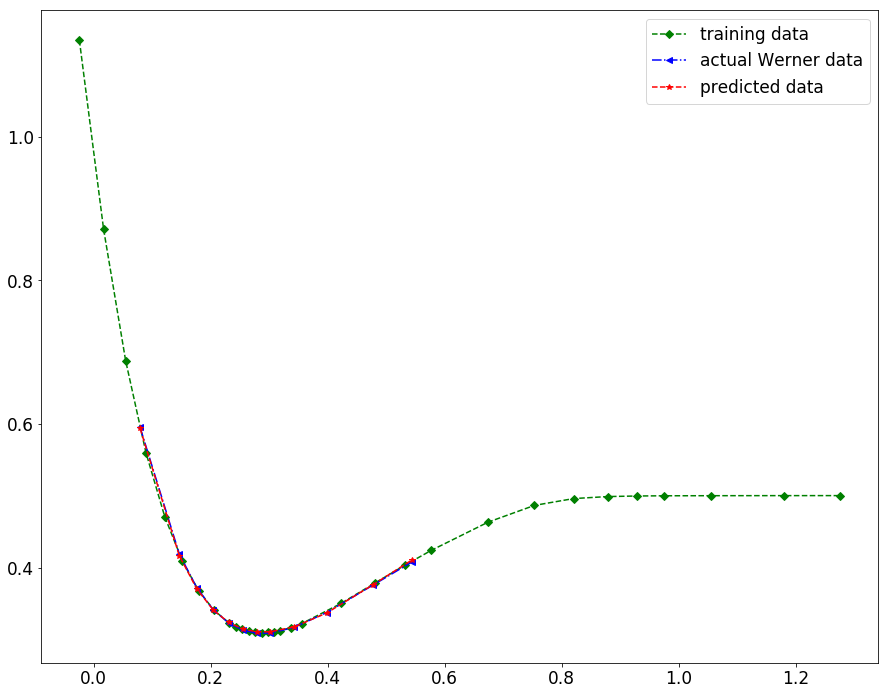

In [16]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(15, 12))
plt.plot(np.log10(R), V, "g--D")
plt.plot(np.log10(R_test), V_test, "b-.<")
plt.plot(np.log10(R_test), p_V_test, "r--*")
plt.legend(["training data","actual Werner data", "predicted data"])

### Cubic spline

training RMSE = 0.0
testing RMSE = 0.0035166731030738677


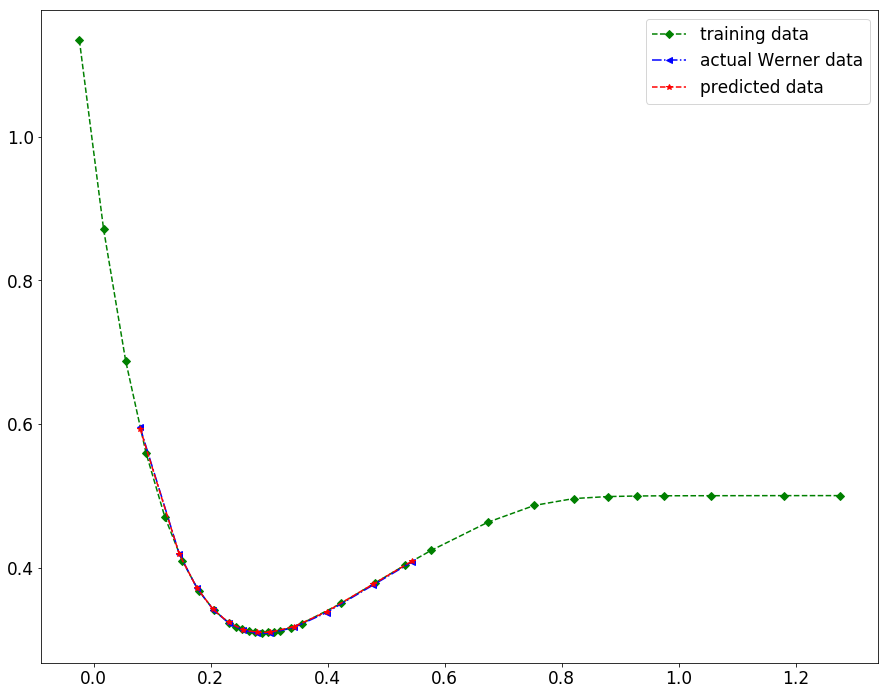

In [29]:
from scipy.interpolate import CubicSpline
cs = CubicSpline(R, V, bc_type='natural')
V_pred = cs(R)
rmse = RMSE(V, V_pred)
print("training RMSE =",rmse)
plt.subplots(figsize=(15, 12))

#predict Werner's V:
V_pred = cs(R_test)
rmse = RMSE(V_test, V_pred)
print("testing RMSE =",rmse)
plt.plot(np.log10(R), V, "g--D")
plt.plot(np.log10(R_test), V_test, "b-.<")
plt.plot(np.log10(R_test), V_pred, "r--*")
plt.legend(["training data","actual Werner data", "predicted data"])

test RMSE = 0.008246436812486388


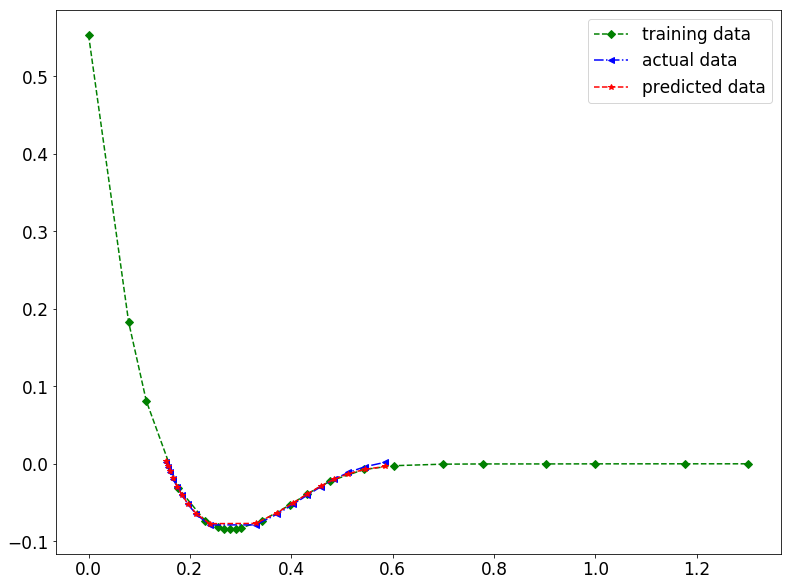

In [38]:
mol = "OH"
qidxs = query_many_vars_indices([mol, "$A^2\Sigma^+$"], ["mol", "state"], list_data)
newidxs = qidxs[1:3]
trainid = newidxs[0]; testid = newidxs[1]
R = list_data[trainid]["R"]; V = list_data[trainid]["V"] # training data
R_test = list_data[testid]["R"]; V_test = list_data[testid]["V"]# test data

cs = CubicSpline(R, V, bc_type='natural')
V_pred = cs(R_test)
print("test RMSE =", RMSE(V_test, V_pred))

plt.subplots(figsize=(13, 10))
plt.plot(np.log10(R), V, "g--D")
plt.plot(np.log10(R_test), V_test, "b-.<")
plt.plot(np.log10(R_test), V_pred, "r--*")
plt.legend(["training data","actual data", "predicted data"])

### Model 041021

residual =  [6.26993857e-08 3.37775687e-07 1.24525425e-10 1.31078826e-07
 1.00621484e-07 4.83974034e-09 2.49985341e-08 6.62266730e-08
 4.84628518e-08 2.75739942e-08 9.70722669e-09 6.67285361e-10
 2.00686547e-09 1.10201622e-08 2.24702251e-08 3.06994101e-08
 3.28100399e-08 1.62031885e-08 3.94437897e-11 2.14749242e-07
 4.29919692e-11 2.09144001e-07 1.04761908e-07 4.62991031e-09
 5.99056493e-10 9.06920085e-11 4.12289095e-12 5.78492933e-13
 7.82263030e-13 9.26641495e-13 3.90367332e-12 5.51563500e-11]
RMSE =  0.00021390044569069021

`xtol` termination condition is satisfied.
Function evaluations 284, initial cost 3.9022e+36, final cost 1.3901e-04, first-order optimality 4.29e+18.
`xtol` termination condition is satisfied.
RMSE =  0.002947606656112963

RMSE = 0.0

`ftol` termination condition is satisfied.
Function evaluations 307, initial cost 2.0771e+10, final cost 1.1915e-01, first-order optimality 5.25e-02.
`ftol` termination condition is satisfied.
RMSE =  0.08629657007652229


C:\Users\beryl\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3325: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


'\nZ = (1,1) #reduce the effect of nuclear charge:\nres = least_squares(f_obj_diatomic_pot_res, C0, args=(f_diatomic_pot_lr, V, R, Z), verbose=1, method="lm")\nprint(res.message)\nV_pred = [f_diatomic_pot_lr(res.x, r, Z) for r in R]\nprint("RMSE = ",RMSE(V_pred, V))\nplt.subplots(figsize=(15, 12))\nplt.plot(np.log(R), V, "bD")\nplt.plot(np.log(R), V_pred)\nplt.title("nonlinear diatomic with least squares, degree = "+str(M)+"; Z=1")\n'

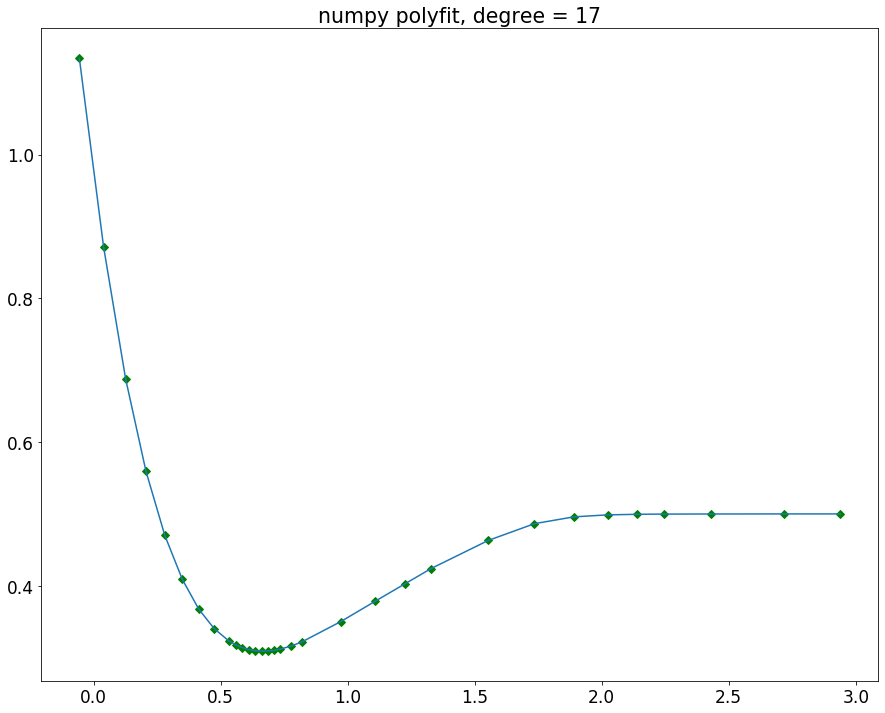

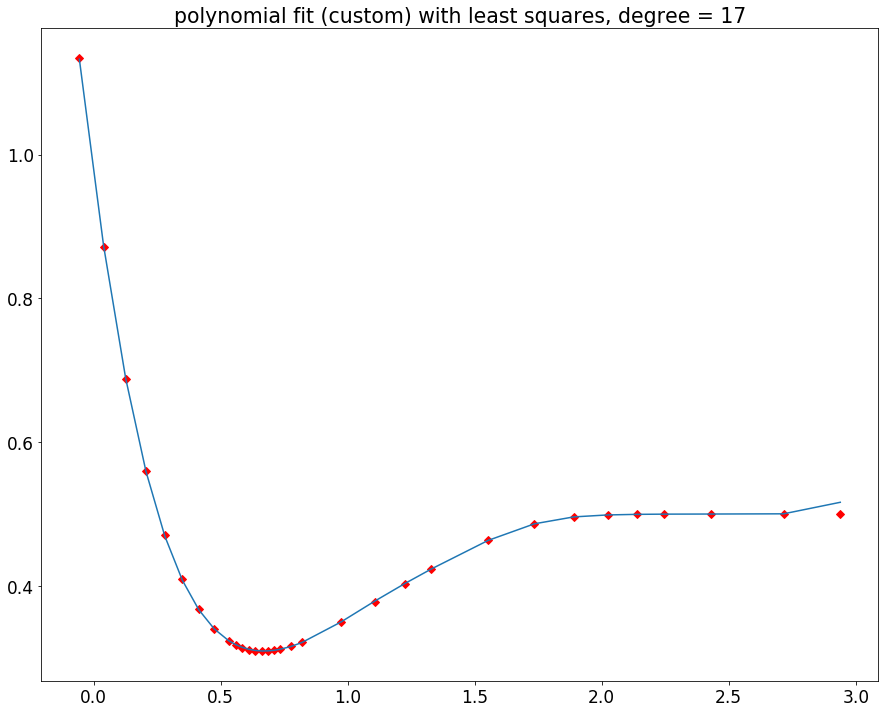

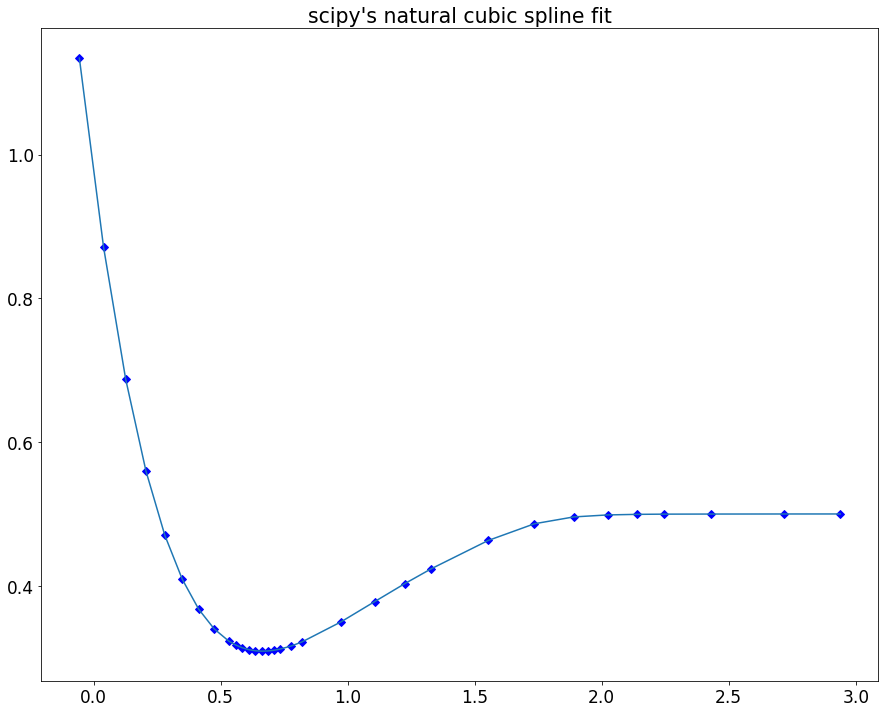

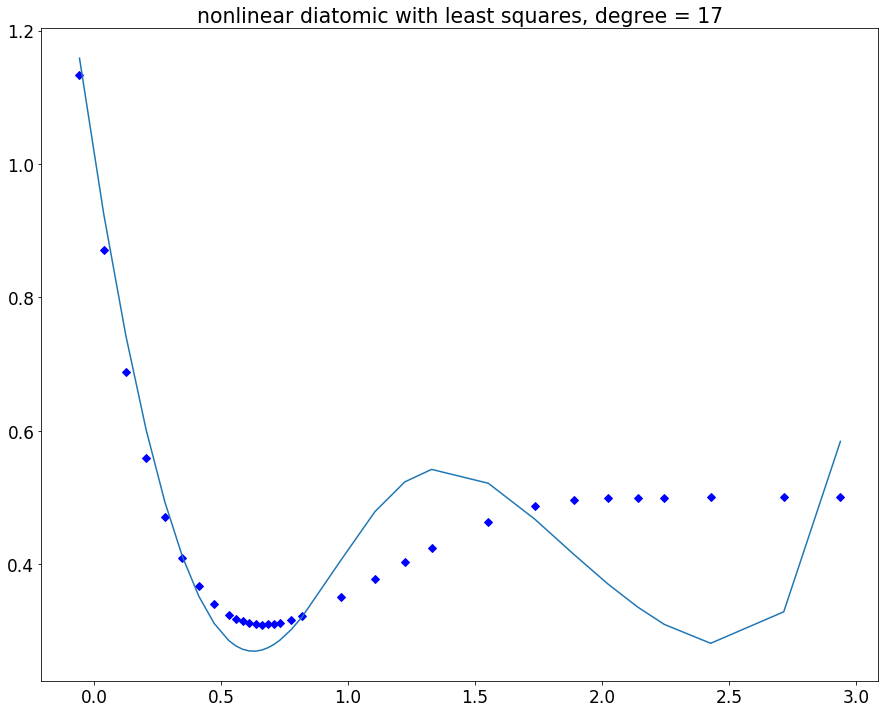

In [58]:
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 17})

mol = "OH+"
qidxs = query_one_var_indices(mol, "mol", list_data)
#train and test on idx 4:
idx = 4
R = list_data[qidxs[idx]]["R"]
V = list_data[qidxs[idx]]["V"]
M = 17
#C0 = np.random.uniform(0, 1, size=(M)) #to avoid division by 0
C0 = np.zeros(M) + 1e-2
Z = (1, 8) #atomic number of atom_1 and atom_2 (permutationally symmetric)
poly_par = {"M":M, "morse":False}


C = np.polyfit(R, V, M) #automatic fit by numpy
e = f_poly_res(C[::-1], f_monomial_diatomic_pot, R, V, poly_par)
print("residual = ",e) #the residual function is correct
#p = np.poly1d(C)
#V_pred = p(R)
V_pred = [f_monomial_diatomic_pot(r, C[::-1], poly_par["morse"]) for r in R] #doublecheck the residual function
print("RMSE = ",RMSE(V_pred, V)) #the polynomial function is correct
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "gD")
plt.plot(np.log(R), V_pred)
plt.title("numpy polyfit, degree = "+str(M))
print()

#using polynomial fit but manual leastsquares:
#C0 = C[::-1] #look at the correct C
res = least_squares(f_poly_res2, C0, args=(f_monomial_diatomic_pot, R, V, poly_par), verbose=1, method="lm")
print(res.message)
V_pred = np.array([f_monomial_diatomic_pot(r, res.x, poly_par["morse"]) for r in R])
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "rD")
plt.plot(np.log(R), V_pred)
plt.title("polynomial fit (custom) with least squares, degree = "+str(M))
print()

#cubic spline:
cs = CubicSpline(R, V, bc_type='natural')
V_pred = cs(R)
print("RMSE =", RMSE(V, V_pred))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred)
plt.title("scipy's natural cubic spline fit")
print()

#using the 2nd proposed method:
#soln = dfbgn.solve(f_obj_diatomic_pot_lr, C0, args=(f_diatomic_pot_lr, V, R, Z))
#print(soln) #dfbgn fails

res = least_squares(f_obj_diatomic_pot_res, C0, args=(f_diatomic_pot_lr, V, R, Z), verbose=1, method="lm")
print(res.message)
V_pred = [f_diatomic_pot_lr(res.x, r, Z) for r in R]
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred)
plt.title("nonlinear diatomic with least squares, degree = "+str(M))

'''
Z = (1,1) #reduce the effect of nuclear charge:
res = least_squares(f_obj_diatomic_pot_res, C0, args=(f_diatomic_pot_lr, V, R, Z), verbose=1, method="lm")
print(res.message)
V_pred = [f_diatomic_pot_lr(res.x, r, Z) for r in R]
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred)
plt.title("nonlinear diatomic with least squares, degree = "+str(M)+"; Z=1")
'''

### Models 111021

RMSE =  2.5705069563080277e-05
`xtol` termination condition is satisfied.
Function evaluations 5444, initial cost 4.3901e+06, final cost 5.0420e-12, first-order optimality 8.97e-12.
`xtol` termination condition is satisfied.
RMSE =  0.0006143181653239701
C after fit [ 1.00326705e-04  3.93890773e-01  9.61456744e-01  2.73972080e-01
  4.95497283e-01  7.20694541e-01  3.18155302e+00 -2.52199012e+00
  6.17792211e-03  2.35419981e-01  3.20785555e+00  9.06109815e-01
  1.72135309e+00  1.34840978e+00  3.57184273e-01  1.75296370e-02
  1.90011453e+00  5.28383088e-01 -2.62286774e-02]
RMSE =  0.0002595565749216328


Text(0.5,1,'OH+ CHIPR lmfit')

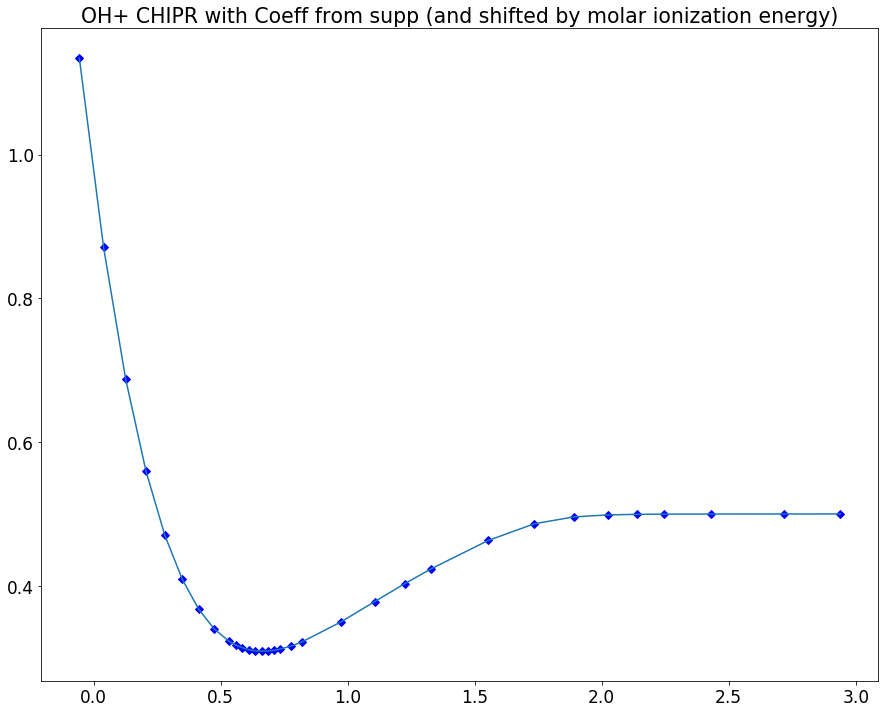

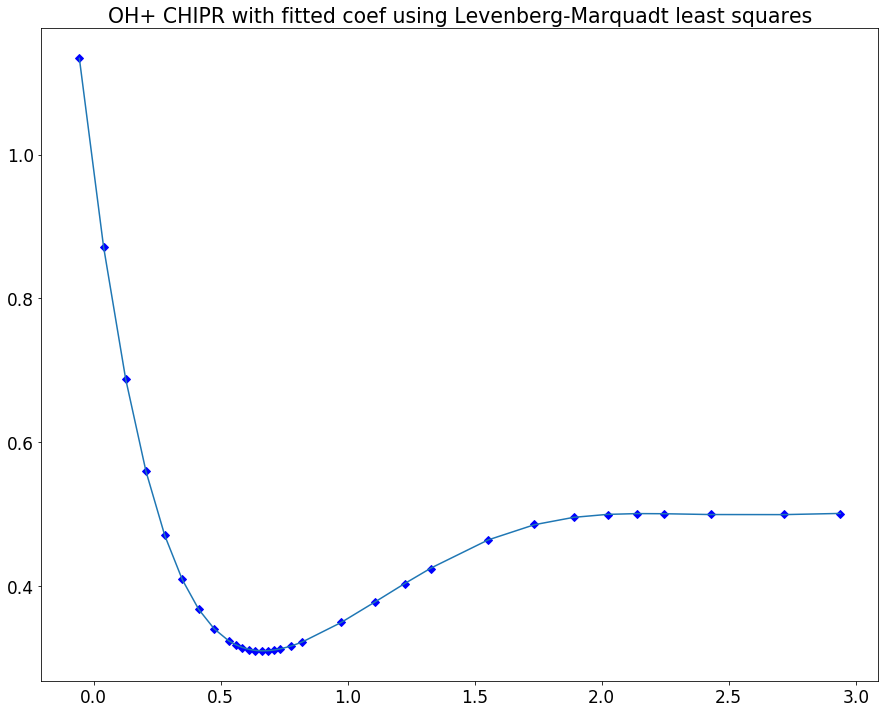

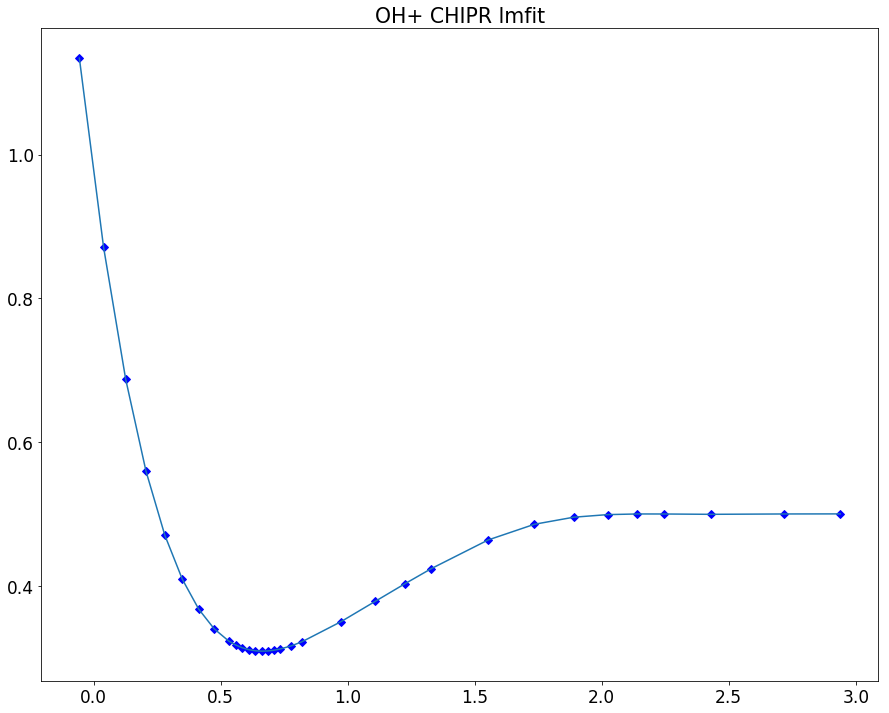

In [103]:
# molecule OH+
mol = "OH+"
qidxs = query_one_var_indices(mol, "mol", list_data)
idx = 4
R = list_data[qidxs[idx]]["R"]
V = list_data[qidxs[idx]]["V"]

#CHIPR:
C = np.array([8.57082, 0.921,
              -3.56097,  0.238234, 2.40785, 0.656067,
              0.378471, 1.7461, 5.91989, 8.5025,
              0.00683275,
              0.255374, 0.75669, 0.0664867, 0.358579,
              1.90036, 0.952497, 45.2516, 1.36563
             ]) #for chipr, from supp https://pubs.acs.org/doi/suppl/10.1021/acs.jpca.8b12005/suppl_file/jp8b12005_si_001.pdf
V_pred = f_diatomic_chipr_ohplus(C, R)
shift_O = 1313.9*0.00038088
print("RMSE = ",RMSE(V_pred+shift_O, V))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred+shift_O) #shift by 0.5
plt.title("OH+ CHIPR with Coeff from supp (and shifted by molar ionization energy)")

F = f_obj_diatomic_pot_res(C, f_diatomic_chipr_ohplus, V, R)
##refit using LM LS:
C0 = np.random.uniform(0, 1, 19)
res = least_squares(f_obj_diatomic_pot_res, C0, args=(f_diatomic_chipr_ohplus, V, R), verbose=1, method="lm")
print(res.message)
V_pred = f_diatomic_chipr_ohplus(res.x, R)
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred)
plt.title("OH+ CHIPR with fitted coef using Levenberg-Marquadt least squares")

##refit using lmfit:
C0 = np.random.uniform(0, 1, 19)+1e-9
C_params = Parameters()
for i, c in enumerate(C0):
    C_params.add(name="c"+str(i), value=c, min=-np.inf, max=np.inf)
out = minimize(f_obj_diatomic_pot_res_lmfit, C_params, args=(f_diatomic_chipr_ohplus, V, R), method='leastsq')
#transform out.params to C array:
C = np.array([out.params[key] for key in out.params])
print("C after fit",C)

#fit = f_obj_diatomic_pot_res_lmfit(out.params, F)
#report_fit(out, show_correl=True, modelpars=V)

V_pred = f_diatomic_chipr_ohplus(C, R)
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred)
plt.title("OH+ CHIPR lmfit")

C after fit [1.49823135e+00 3.25362336e+01 7.66026236e+01 7.89872612e-11]
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 5635
    # data points      = 32
    # variables        = 4
    chi-square         = 1.06377258
    reduced chi-square = 0.03799188
    Akaike info crit   = -100.925257
    Bayesian info crit = -95.0623132
##  Warning: uncertainties could not be estimated:
    c3:  at boundary
[[Variables]]
    c0:  1.49823135 (init = 0.3921907)
    c1:  32.5362336 (init = 0.6945392)
    c2:  76.6026236 (init = 0.944967)
    c3:  7.8987e-11 (init = 0.1633825)
RMSE =  0.1823263368864855
C after fit [ 1.00000000e-09 -4.20157654e+07 -1.09413667e-09 -1.34721566e+00
 -1.22458432e-09  1.00000000e-09  0.00000000e+00]
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 32
    # variables        = 6
    chi-square         = 7.36874417
    reduced chi-square = 0.28341324
    Akaike info crit   = -34.9916355
    

Text(0.5,1,'OH+ Deiters-Sadus lmfit')

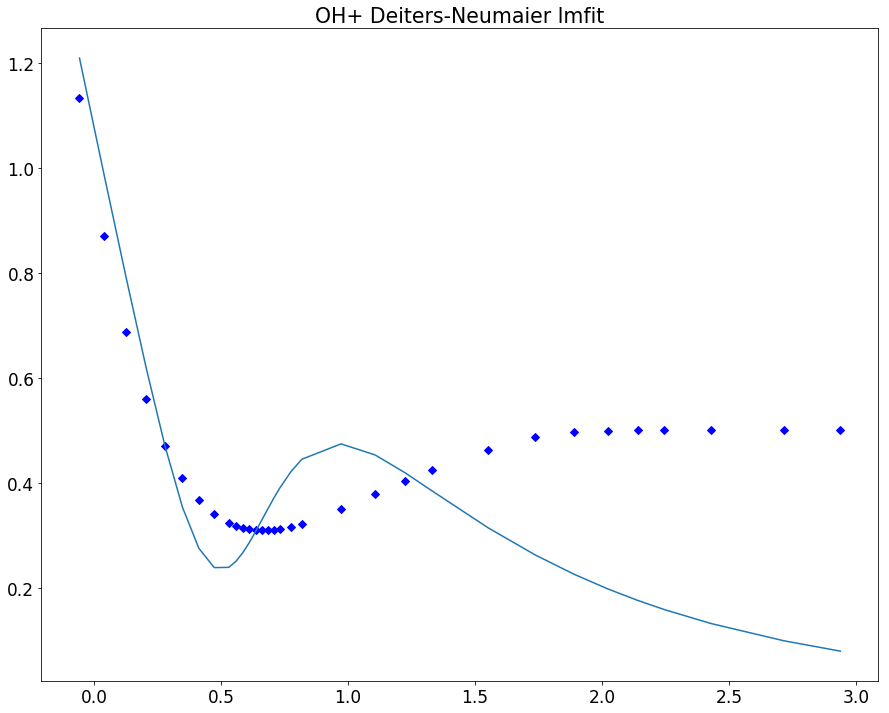

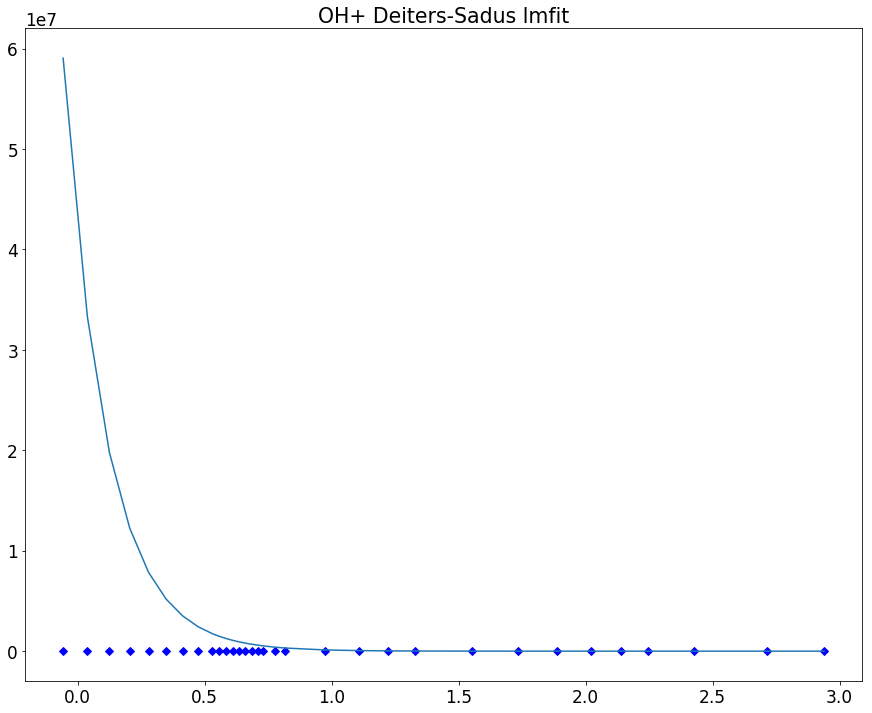

In [78]:
#Deiters-Neumaier:
'''
#from available coeffs (for Argon)
C = [1.639146038e9, 7.075527590e5, 2.726770354e4, 2.503350833] #from table 1 https://pubs-acs-org.uaccess.univie.ac.at/doi/full/10.1021/acs.jced.6b00133#
V_pred = f_diatomic_dn(C, R)
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred)
plt.title("Deiters-Neumaier OH+, coeffs from table")
'''
##lmfit:
C0 = np.random.uniform(0,1,4) #4 free parameters
C_params = Parameters()
for i, c in enumerate(C0):
    C_params.add(name="c"+str(i), value=c, min=0, max=np.inf)
out = minimize(f_obj_diatomic_pot_res_lmfit, C_params, args=(f_diatomic_dn, V, R), method="leastsq")
#transform out.params to C array:
C = np.array([out.params[key] for key in out.params])
print("C after fit",C)

#fit = f_obj_diatomic_pot_res_lmfit(out.params, F)
report_fit(out, show_correl=True, modelpars=V)

V_pred = f_diatomic_dn(C, R)
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred)
plt.title("OH+ Deiters-Neumaier lmfit")

#Deiters-Sadus:
## initial points, c[1:5] < 0; c[[0, 5]] > 0, c[6] = 0

C0 = np.random.uniform(-1,-1e-9,7) #7 free parameters 
C_params = Parameters()
C_params.add(name="c0", value=C0[0], min=1e-9, max=np.inf)
for i in range(1, 5):
    C_params.add(name="c"+str(i), value=C0[i], min=-np.inf, max=-1e-9)
C_params.add(name="c5", value=C0[5], min=1e-9, max=np.inf)
C_params.add(name="c6", value=0, vary=False)

out = minimize(f_obj_diatomic_pot_res_lmfit, C_params, args=(f_diatomic_ds, V, R), method="leastsq")
#transform out.params to C array:
C = np.array([out.params[key] for key in out.params])
print("C after fit",C)
report_fit(out, show_correl=True, modelpars=V)

V_pred = f_diatomic_dn(C, R)
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred)
plt.title("OH+ Deiters-Sadus lmfit")

[ 0.45202643 -0.56713766 14.99790643 14.21165152 16.94242195]
[ 0.94486299  1.03934929  1.13383559  1.22832189  1.32280819  1.41729449
  1.51178079  1.60626709  1.70075339  1.74799654  1.79523969  1.84248284
  1.88972599  1.93696914  1.98421229  2.03145544  2.07869859  2.17318489
  2.26767119  2.64561638  3.02356158  3.40150678  3.77945198  4.72431497
  5.66917797  6.61404096  7.55890395  8.50376695  9.44862994 11.33835593
 15.11780791 18.89725989]


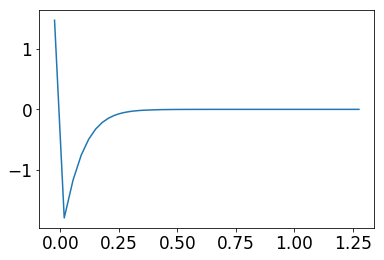

In [222]:
# test print the function:
C = np.array([0.45202643, -0.56713766, 14.99790643, 14.21165152, 16.94242195])
print(C)
R_temp = np.linspace(0, 10, 100)
V_pred = f_diatomic_vdw(C, R, 8)
plt.plot(np.log10(R), V_pred)
print(R)

C after fit [ 2.10206586e-01  4.09675527e-01  4.75975057e+03  7.22295186e+01
 -1.37366180e+02]
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 176
    # data points      = 32
    # variables        = 5
    chi-square         = 3.88452756
    reduced chi-square = 0.14387139
    Akaike info crit   = -57.4795051
    Bayesian info crit = -50.1508255
[[Variables]]
    c0: -0.21020659 +/- 0.13862661 (65.95%) (init = -0.1961996)
    c1:  0.40967553 +/- 0.17790764 (43.43%) (init = 0.652163)
    c2:  4759.75057 +/- 3.2955e+09 (69236779.61%) (init = 0.5371096)
    c3:  72.2295186 +/- 1.1365e+09 (1573423296.77%) (init = 0.1695352)
    c4: -137.366180 +/- 95786284.3 (69730616.76%) (init = -0.05230811)
[[Correlations]] (unreported correlations are < 0.100)
    C(c3, c4) = -0.998
    C(c2, c3) = -0.998
    C(c2, c4) =  0.992
    C(c0, c1) = -0.957
    C(c1, c2) = -0.504
    C(c1, c3) =  0.501
    C(c1, c4) = -0.496
    C(c0, c2) =  0.413
    C(c0, c3) = -0.410
    C(c0, 

Text(0.5,1,'OH+ 3rd model lmfit')

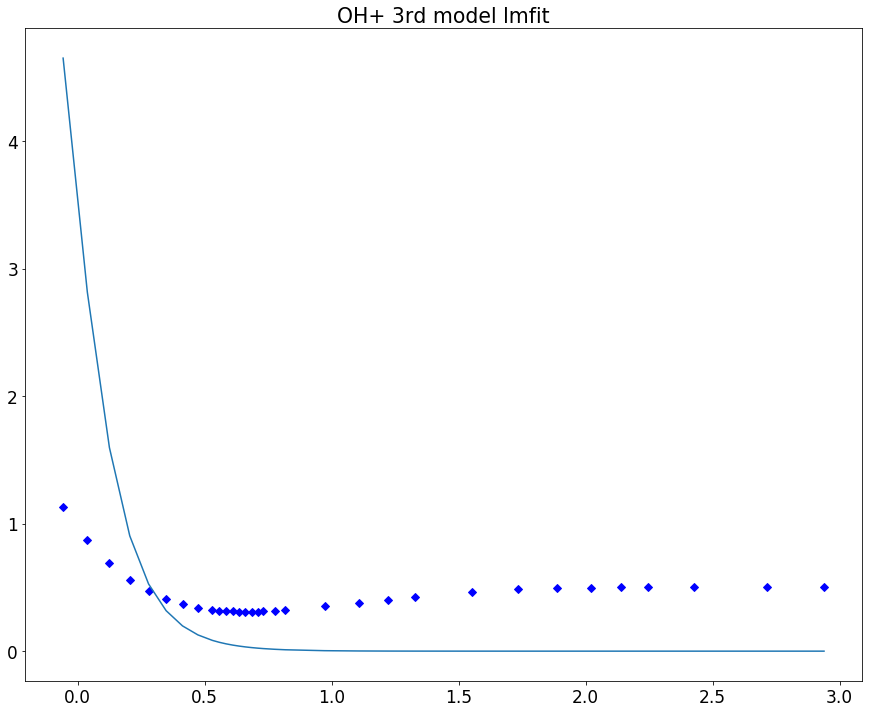

In [161]:
#new proposed model:
'''
C0 = np.zeros(5)
tempC = np.random.uniform(1e-2, 1e9, 2)
C0[0] = tempC[0]; C0[2] = tempC[1]
Z = 8
f_diatomic_vdw(C0, R, Z)
res = least_squares(f_obj_diatomic_pot_res, C0, args=(f_diatomic_vdw, V, R, Z), verbose=1)
print(res.message)
V_pred = f_diatomic_dn(res.x, R)
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred)
plt.title("OH+ Deiters-Neumaier with fitted coef using Levenberg-Marquadt least squares")
'''
##lmfit:
#C1 and C3 > 0
C0 = np.random.uniform(-1, 1, 5) #5 free parameters
#add params:
C_params = Parameters()
for i, c in enumerate(C0):
    C_params.add(name="c"+str(i), value=c, min=-np.inf, max=np.inf)

out = minimize(f_obj_diatomic_pot_res_lmfit, C_params, args=(f_diatomic_vdw, V, R, 8), method="leastsq")
#transform out.params to C array:
C = np.array([out.params[key] for key in out.params])
#C0->|C0|, C2->|C2|:
C[0] = np.abs(C[0]); C[2] = np.abs(C[2])

print("C after fit",C)

#fit = f_obj_diatomic_pot_res_lmfit(out.params, F)
report_fit(out, show_correl=True, modelpars=V)

V_pred = f_diatomic_vdw(C, R, 8)
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred)
plt.title("OH+ 3rd model lmfit")

0 th round is done
rmse =  0.8066566070871372
[  0.21021511   0.40969383 126.31964268  41.51368472 -79.25874067]


Text(0.5,1,'OH+ 3rd model lmfit')

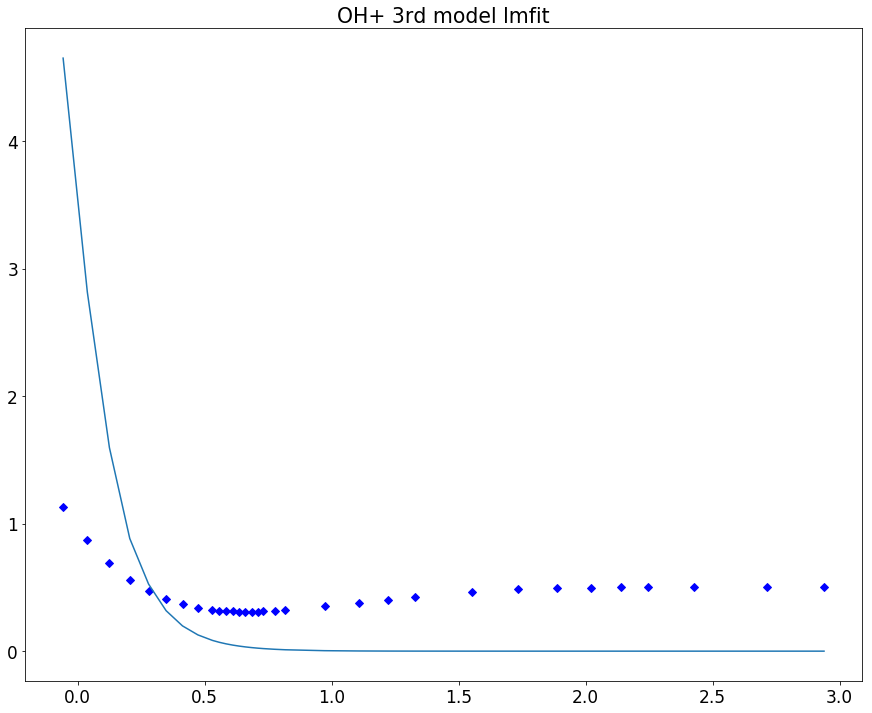

In [231]:
##finding the global optimum by multiple starting points, take the lowest RMSE:
def multistart(n, delta, mode='default'):
    #randomize by power x2 each loop and alternate sign:
    #n =  max loop
    #delta = minimum RMSE
    #the data are global var
    pwr = 1
    min_rmse = np.inf
    min_C = np.zeros(5)
    for k in range(n):
        C_params = Parameters()
        if mode == "default":
            C0 = np.random.uniform(-1, 1, 5)*pwr
            for i, c in enumerate(C0):
                C_params.add(name="c"+str(i), value=c, min=-np.inf, max=np.inf)
        elif mode == "alternate":
            #vector with alternating sign:
            C0 = np.random.uniform(0, 1, 5)*pwr
            for i, c in enumerate(C0):
                val = c
                if i%2 == 0:
                    val = -c
                C_params.add(name="c"+str(i), value=val, min=-np.inf, max=np.inf)
        #minimization routine and objective function here:
        out = minimize(f_obj_diatomic_pot_res_lmfit, C_params, args=(f_diatomic_vdw, V, R, 8), method="cg")
        #transform out.params to C array:
        C = np.array([out.params[key] for key in out.params])
        #C0->|C0|, C2->|C2|:
        C[0] = np.abs(C[0]); C[2] = np.abs(C[2])
        #get the predicted V
        V_pred = f_diatomic_vdw(C, R, 8)
        rmse = RMSE(V_pred, V)
        #get the minimum rmse:
        if rmse < min_rmse:
            min_rmse = rmse
            min_C = C
        #stop if delta is satisfied:
        if min_rmse <= delta:
            break
        #increase power or alternate sign
        if k%2 != 0:
            pwr *= 2
        else:
            pwr *= -1 #alternate sign
    return min_rmse, min_C

def multiple_multistart(k, n, delta, mode="default"):
    #k = number of restarts
    min_rmse = np.inf; min_C = None
    for i in range(k):
        res = multistart(n, delta, mode)
        print(i,"th round is done")
        rmse = res[0]; C = res[1];
        if rmse < min_rmse:
            min_rmse = rmse
            min_C = C
        if rmse <= delta:
            break
    return min_rmse, min_C

rmse, C = multiple_multistart(1, int(1.75e2), 1e-2, mode= "alternate")
print("rmse = ",rmse)
print(C)
V_pred = f_diatomic_vdw(C, R, 8)
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred)
plt.title("OH+ 3rd model lmfit")

In [206]:
rmse =  0.7608358031159257
[ 0.45202643 -0.56713766 14.99790643 14.21165152 16.94242195]

rmse =  0.3388745479985727
[ 1.40190265  1.6732669   0.85488082 -1.37075425  0.85787211]


rmse =  0.3044378687788408
[ 1.58502333e+00  1.02774471e+02  6.17834991e-01 -3.31775174e-01
  9.75283009e-02]

SyntaxError: invalid syntax (<ipython-input-206-1af3dd5362fa>, line 2)

C after fit [-1.05134424 -2.22507655]
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 32
    # variables        = 2
    chi-square         = 3.78443419
    reduced chi-square = 0.12614781
    Akaike info crit   = -64.3148644
    Bayesian info crit = -61.3833926
[[Variables]]
    c0: -1.05134424 +/- 0.53445594 (50.84%) (init = -9.29927e+08)
    c1: -2.22507655 +/- 0.64636791 (29.05%) (init = -4.031011e+08)
[[Correlations]] (unreported correlations are < 0.100)
    C(c0, c1) =  0.948
RMSE =  0.34389470567675695


Text(0.5,1,'OH+ LJ lmfit')

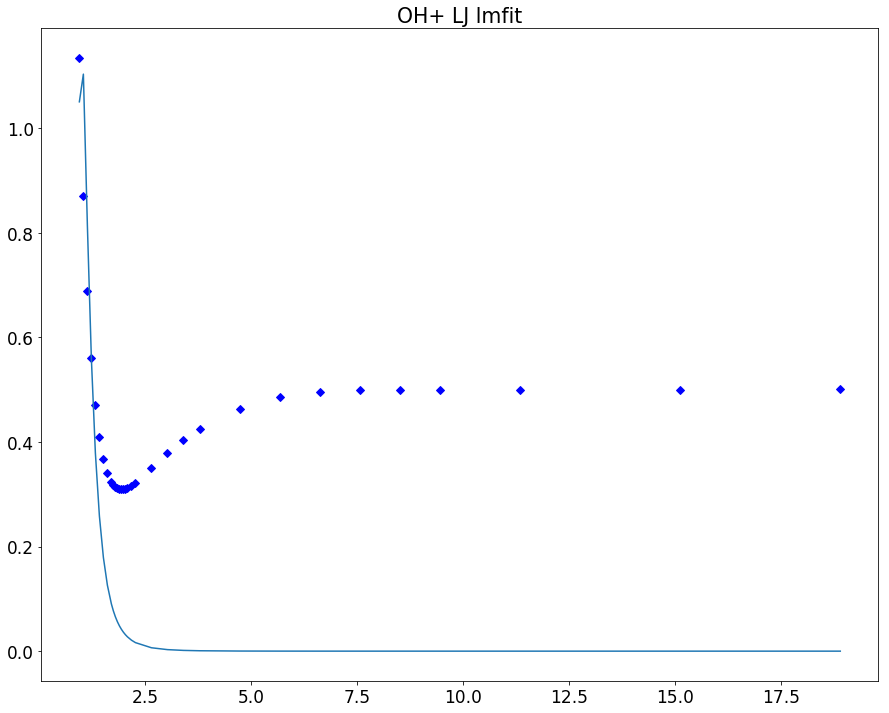

In [221]:
C0 = np.random.uniform(-1e9, 1e9, 2)
C_params = Parameters()
for i, c in enumerate(C0):
    C_params.add(name="c"+str(i), value=c, min=-np.inf, max=np.inf)

out = minimize(f_obj_diatomic_pot_res_lmfit, C_params, args=(f_lj_pot, V, R), method="leastsq")
C = np.array([out.params[key] for key in out.params])
print("C after fit",C)

#fit = f_obj_diatomic_pot_res_lmfit(out.params, F)
report_fit(out, show_correl=True, modelpars=V)

V_pred = f_lj_pot(C, R)
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
plt.plot(R, V, "bD")
plt.plot(R, V_pred)
plt.title("OH+ LJ lmfit")